# Prophet vs ARIMA Forecasting App

This project compares time-series forecasting using two models: Prophet and ARIMA.

- **Dataset used**: User-uploaded CSV with `date` and target column
- **Models**: Prophet, ARIMA
- **Goal**: Forecast future values and compare performance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor, plot_importance
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("climate_nasa.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['year'] = df['date'].dt.year
df['week_no'] = df['date'].dt.isocalendar().week
df = df.dropna(thresh=int(0.85 * df.shape[1]))


In [3]:
year_col = df['year']
week_col = df['week_no']
df_num = df.select_dtypes(include=np.number)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
df_imputed['year'] = year_col.fillna(year_col.median()).astype(int)
df_imputed['week_no'] = week_col.fillna(week_col.median()).astype(int)
df_imputed['timestamp'] = pd.to_datetime(df_imputed['year'].astype(str) + df_imputed['week_no'].astype(str) + '0', format='%G%V%w')

In [4]:
# Detect target column
print(df_imputed.columns)

emission_col = 'likesCount'  # or 'commentsCount'


# Feature engineering
df_imputed['lag_emission'] = df_imputed[emission_col].shift(1)
df_imputed['rolling_mean_3'] = df_imputed[emission_col].rolling(window=3).mean()
df_imputed['rolling_std_3'] = df_imputed[emission_col].rolling(window=3).std()
df_imputed = df_imputed.dropna()

# Define features and target
X = df_imputed.drop(columns=[emission_col, 'timestamp'], errors='ignore')
y = df_imputed[emission_col]


Index(['likesCount', 'commentsCount', 'year', 'week_no', 'timestamp'], dtype='object')


In [5]:
y_log = np.log1p(y)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
params = {
    'num_leaves': [15, 31],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 300],
    'max_depth': [3, 4]
}
grid = GridSearchCV(LGBMRegressor(random_state=42), params, cv=3, scoring='r2')
grid.fit(X_train_scaled, y_train_log)
print("Best Parameters:", grid.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 277, number of used features: 6
[LightGBM] [Info] Start training from score 0.900278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [7]:
model = grid.best_estimator_
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

MAE: 4.150518733591271
MSE: 152.01708383601311
R2: 0.14121774375293838
MAPE: 917011016515072.5


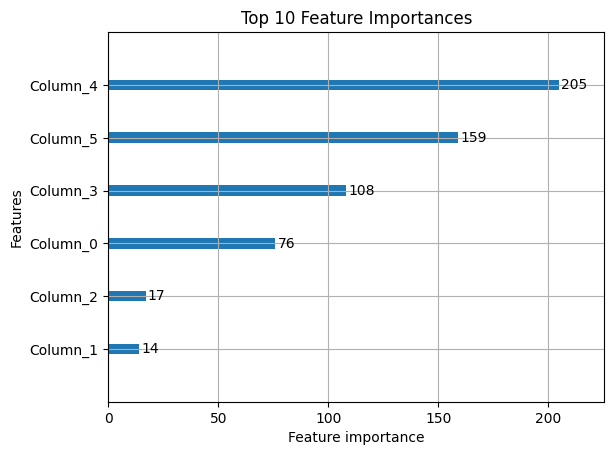

In [8]:
plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

13:46:32 - cmdstanpy - INFO - Chain [1] start processing
13:46:33 - cmdstanpy - INFO - Chain [1] done processing


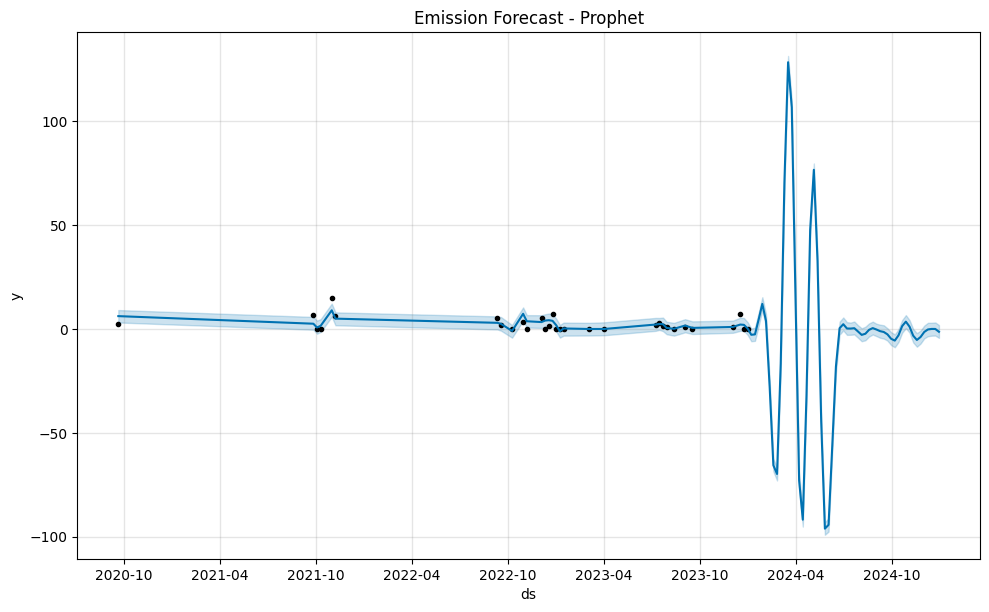

In [9]:
df_prophet = df_imputed[['timestamp', emission_col]].rename(columns={'timestamp': 'ds', emission_col: 'y'})
df_prophet = df_prophet.groupby('ds').mean().reset_index()
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=52, freq='W')
forecast = m.predict(future)
m.plot(forecast)
plt.title("Emission Forecast - Prophet")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# 1. Load and prepare data
df = pd.read_csv("climate_nasa.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# Choose the correct target
target = 'likesCount'  # or 'commentsCount' if needed

# Aggregate weekly and clean
ts_df = df[['date', target]].copy()
ts_df = ts_df.groupby('date').mean().reset_index()
ts_df = ts_df.rename(columns={'date': 'ds', target: 'y'})

# Remove extreme outliers
q_low = ts_df['y'].quantile(0.01)
q_high = ts_df['y'].quantile(0.99)
ts_df = ts_df[(ts_df['y'] >= q_low) & (ts_df['y'] <= q_high)]

# Apply rolling smoothing
ts_df['y'] = ts_df['y'].rolling(window=3, center=True).mean()
ts_df = ts_df.dropna()

# ========== PROPHET ========== #
# ========== PROPHET ========== #
prophet_df = ts_df.copy()
prophet_df['ds'] = pd.to_datetime(prophet_df['ds']).dt.tz_localize(None)  # <- Fix here

prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=26, freq='W')
forecast = prophet_model.predict(future)

# Plot Prophet forecast
fig1 = prophet_model.plot(forecast)
plt.title("📈 Prophet Forecast (Smoothed + Clipped)")
plt.show()

# ========== ARIMA ========== #
arima_series = ts_df.set_index('ds')['y']
arima_model = ARIMA(arima_series, order=(2, 1, 2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=26)

# Plot ARIMA
plt.figure(figsize=(10, 5))
plt.plot(arima_series[-100:], label='Historical')
plt.plot(arima_forecast.index, arima_forecast, label='ARIMA Forecast', color='orange')
plt.title("📉 ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()


ValueError: Column ds has timezone specified, which is not supported. Remove timezone.